## Importing various packages and load data with Google Drive.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt

In [37]:
from google.colab import drive
drive.mount('/content/drive')

# Now we can read the file by its name.
data_path = 'drive/MyDrive/laser_WCA.xlsx'
data = pd.read_excel(data_path)

print(data.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Data Source  laser fluence/(J/cm²)  focal length/mm  \
0            1                  0.000            250.0   
1            1                  0.290            250.0   
2            1                  0.550            250.0   
3            1                  0.876            250.0   
4            1                  1.190            250.0   

   essential WCA without decoration/°  essential WCA with drcoration/°  \
0                                87.0                           114.81   
1                                87.0                           114.81   
2                                87.0                           114.81   
3                                87.0                           114.81   
4                                87.0                           114.81   

  scanning method  line spacing/µm  scanning speed/(mm/s)  spot size/µm  \
0 

## Preprocessing
The data consists of several different types of data:

* Data Source
* laser fluence/(J/cm²)
* focal length/mm
*	essential WCA without decoration/°
*	essential WCA with drcoration/°
*	scanning method	line spacing/µm
*	scanning speed/(mm/s)
* spot size/µm
*	center wave length/nm
*	pulse duration/fs
*	laser frequency/kHz
*	WCA/°



In [38]:
# The basic info of the data.
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Data Source                         276 non-null    int64  
 1   laser fluence/(J/cm²)               276 non-null    float64
 2   focal length/mm                     268 non-null    float64
 3   essential WCA without decoration/°  276 non-null    float64
 4   essential WCA with drcoration/°     276 non-null    float64
 5   scanning method                     276 non-null    object 
 6   line spacing/µm                     276 non-null    float64
 7   scanning speed/(mm/s)               276 non-null    float64
 8   spot size/µm                        276 non-null    float64
 9   center wave length/nm               276 non-null    int64  
 10  pulse duration/fs                   276 non-null    int64  
 11  laser frequency/kHz                 276 non-n

### Dealing with the missing data

Using interpolation, machine learning prediction and deletion.

In [39]:
columns_to_drop = [
    "Data Source",
    "Unnamed: 13",
    "Unnamed: 14"
]

# Drop the specified columns
data = data.drop(columns=columns_to_drop)

# Drop rows with any NaN values
data.dropna(inplace=True)

# Print the first few rows of the modified data
print(data.head())

   laser fluence/(J/cm²)  focal length/mm  essential WCA without decoration/°  \
0                  0.000            250.0                                87.0   
1                  0.290            250.0                                87.0   
2                  0.550            250.0                                87.0   
3                  0.876            250.0                                87.0   
4                  1.190            250.0                                87.0   

   essential WCA with drcoration/° scanning method  line spacing/µm  \
0                           114.81   perpendicular             20.0   
1                           114.81   perpendicular             20.0   
2                           114.81   perpendicular             20.0   
3                           114.81   perpendicular             20.0   
4                           114.81   perpendicular             20.0   

   scanning speed/(mm/s)  spot size/µm  center wave length/nm  \
0                  40

In [40]:
print(data.shape)

(268, 12)


In [41]:
# Convert the 'scanning method' column to numerical using Label Encoding
label_encoder = LabelEncoder()
data['scanning method'] = label_encoder.fit_transform(
    data['scanning method']
    )
# Split data into X (features) and y (target)
X = data.drop(columns=['WCA/°'])
y = data['WCA/°']
# Standardize X data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

In [21]:
# Define the model without data-strengthening
input_shape = X_train.shape[1]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_shape,)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

# Compile with an adjusted learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Evaluate the model before training
initial_loss, initial_mae = model.evaluate(X_test, y_test, verbose=0)
print("Initial Test Mean Absolute Error:", initial_mae)

# Train with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, batch_size=32, callbacks=[early_stopping], verbose=0)

# Evaluate the model after training
final_loss, final_mae = model.evaluate(X_test, y_test, verbose=0)
print("Final Test Mean Absolute Error:", final_mae)

Initial Test Mean Absolute Error: 137.09107971191406
Final Test Mean Absolute Error: 22.977954864501953


In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Using Data Strengthening to process the data.

In [2]:
# Data Strengthening
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Selecting
selector = SelectKBest(score_func=f_regression, k='all')  # All features are selected.
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Polynomial Features: Expand the feature set by generating polynomial features (degree 2). This dramatically increases the dimensionality of the dataset and can capture non-linear relationships between features and the target variable.
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_selected)
X_test_poly = poly.transform(X_test_selected)

# Adding noises：preventing overfitting during training
noise_factor = 0.1
X_train_noisy = X_train_poly + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_poly.shape)
X_test_noisy = X_test_poly + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test_poly.shape)

# The neural network
input_shape = X_train_noisy.shape[1]
model = tf.keras.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train_noisy, y_train, epochs=500, validation_split=0.2, batch_size=32, callbacks=[early_stopping], verbose=1)

loss, mae = model.evaluate(X_test_noisy, y_test, verbose=0)
print("Test Mean Absolute Error:", mae)

NameError: name 'X_train' is not defined

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Yet, the significance reduction in MAE could be due to these reasons:
* Potential Data Leakage
* Overfitting
So it is a must to conduct a k-fold cross-validation to get a more reliable assessment.

## k-fold cross-validation used to avoid overfitting and provides a more reliable assessment

In [45]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error


# Defining the cross-validation parameters
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = []

# Cross-validation
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    X_train_poly = poly.fit_transform(X_train_selected)
    X_test_poly = poly.transform(X_test_selected)

    # Training the model.
    model = tf.keras.Sequential([
        layers.Input(shape=(X_train_poly.shape[1],)),
        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model.fit(X_train_poly, y_train, epochs=10000, validation_split=0.2, batch_size=32, callbacks=[early_stopping], verbose=0)

    # Assessment
    predictions = model.predict(X_test_poly)
    mae = mean_absolute_error(y_test, predictions)
    mae_scores.append(mae)

# Results
print(f"Cross-validated Mean Absolute Errors: {mae_scores}")
print(f"Mean MAE: {np.mean(mae_scores)}")
print(f"Standard Deviation of MAE: {np.std(mae_scores)}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Cross-validated Mean Absolute Errors: [0.4411240573282595, 0.5329262735667052, 0.5823105681963541, 0.5706467854061147, 0.5008305896003291]
Mean MAE: 0.5255676548195525
Standard Deviation of MAE: 0.051085573415055444


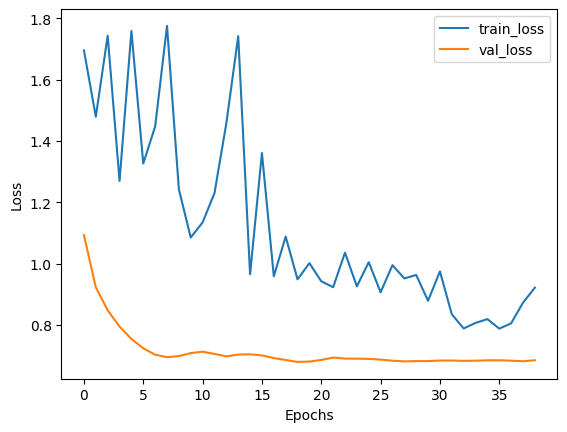

In [44]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Classification Algorithms

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

# Now we can read the file by its name.
data_path = 'drive/MyDrive/laser_WCA.xlsx'
data = pd.read_excel(data_path)
# Preprocess the dataset
data = data.drop(columns=['Unnamed: 13', 'Unnamed: 14', 'Data Source']).dropna()
# Convert the 'scanning method' column to numerical using Label Encoding
label_encoder = LabelEncoder()
data['scanning method'] = label_encoder.fit_transform(
    data['scanning method']
    )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
data['superhydrophobic'] = (data['WCA/°'] > 150).astype(int)

X = data.drop(['WCA/°', 'superhydrophobic'], axis=1)
y = data['superhydrophobic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [29]:
# Using XGB to classify.
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)

# Using Random Forest to classify.
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

# Using SVM to classify.
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)

# Using KNN to Classify
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train, y_train)
knn_accuracy = model.score(X_test, y_test)

# Using GBM.
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
gbm_accuracy = model.score(X_test, y_test)

# Using Decision Trees.
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
dt_accuracy = model.score(X_test, y_test)

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
nb_accuracy = model.score(X_test, y_test)

# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
model.fit(X_train, y_train)
ada_accuracy = model.score(X_test, y_test)

# Print the accuracies
print("XGBoost Accuracy:", xgb_accuracy)
print("Random Forest Accuracy:", rf_accuracy)
print("SVM Accuracy:", svm_accuracy)
print("KNN Accuracy:", knn_accuracy)
print("Gradient Boosting Accuracy:", gbm_accuracy)
print("Decision Tree Accuracy:", dt_accuracy)
print("Naive Bayes Accuracy:", nb_accuracy)
print("AdaBoost Accuracy:", ada_accuracy)

XGBoost Accuracy: 0.8703703703703703
Random Forest Accuracy: 0.8888888888888888
SVM Accuracy: 0.5370370370370371
KNN Accuracy: 0.8703703703703703
Gradient Boosting Accuracy: 0.8333333333333334
Decision Tree Accuracy: 0.8333333333333334
Naive Bayes Accuracy: 0.5370370370370371
AdaBoost Accuracy: 0.8703703703703703


In [30]:
# XGBoost Grid Search Refinement
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# 定义要搜索的超参数范围
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 创建XGBoost分类器
xgb = XGBClassifier(random_state=42)

# 使用网格搜索进行超参数调整
grid_search = GridSearchCV(xgb, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 获取最佳参数和最佳准确率
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation accuracy: ", best_accuracy)

# 使用最佳参数进行预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
best_xgb_accuracy = accuracy_score(y_test, y_pred)

print("XGBoost Test set accuracy with best parameters: ", best_xgb_accuracy)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters found:  {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation accuracy:  0.7756367663344408
XGBoost Test set accuracy with best parameters:  0.9074074074074074


In [31]:
# AdaBoost Grid Search Refinement
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# 基分类器
base_estimator = DecisionTreeClassifier()

# 定义要搜索的超参数范围
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'base_estimator__max_depth': [1, 2, 3, 4, 5]
}

# 创建AdaBoost分类器
ada = AdaBoostClassifier(base_estimator=base_estimator)

# 使用网格搜索进行超参数调整
grid_search = GridSearchCV(ada, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 获取最佳参数和最佳准确率
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation accuracy: ", best_accuracy)

# 使用最佳参数进行预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
best_ada_accuracy = accuracy_score(y_test, y_pred)

print("Test set accuracy with best parameters: ", best_ada_accuracy)


Fitting 5 folds for each of 45 candidates, totalling 225 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best parameters found:  {'base_estimator__max_depth': 1, 'learning_rate': 1, 'n_estimators': 200}
Best cross-validation accuracy:  0.7756367663344407
Test set accuracy with best parameters:  0.8703703703703703


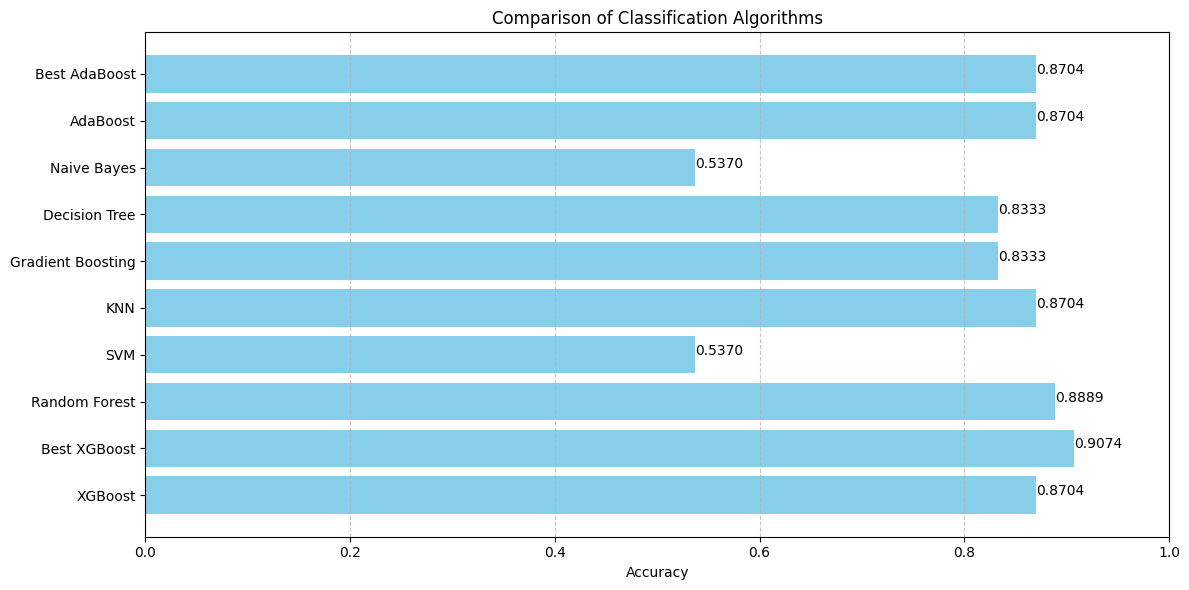

In [32]:
import matplotlib.pyplot as plt

# 准确率数据
algorithms = ['XGBoost','Best XGBoost', 'Random Forest', 'SVM', 'KNN',
             'Gradient Boosting', 'Decision Tree', 'Naive Bayes',
              'AdaBoost','Best AdaBoost']
accuracies = [xgb_accuracy, best_xgb_accuracy, rf_accuracy, svm_accuracy, knn_accuracy,
              gbm_accuracy, dt_accuracy, nb_accuracy,
              ada_accuracy, best_ada_accuracy]


# 创建条形图
plt.figure(figsize=(12, 6))
plt.barh(algorithms, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Comparison of Classification Algorithms')
plt.xlim(0, 1)  # 设置 x 轴范围为 0 到 1
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 在条形图上显示准确率数值
for index, value in enumerate(accuracies):
    plt.text(value, index, f"{value:.4f}")

plt.tight_layout()
plt.show()

Using different methods to ensure the accuracy and overfitting problems addressed by the algorithms.

Evaluating XGBoost...
Cross-validated F1 Score: 0.7508000364221215
Accuracy: 0.8703703703703703
Precision: 0.8820806100217865
Recall: 0.8703703703703703
F1 Score: 0.868312757201646
Confusion Matrix:
[[28  1]
 [ 6 19]]
AUC: 0.9668965517241379


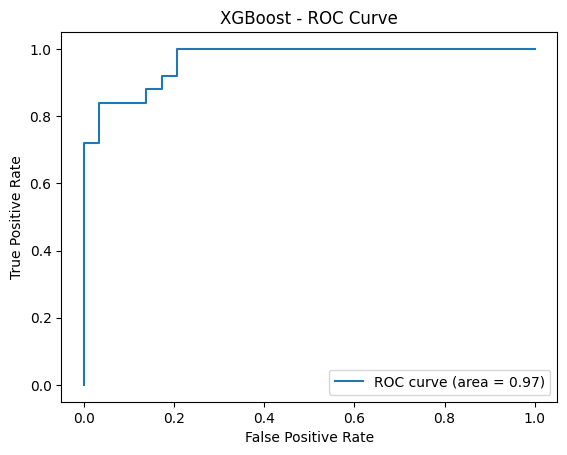

Average Precision (AP): 0.9652384174964821


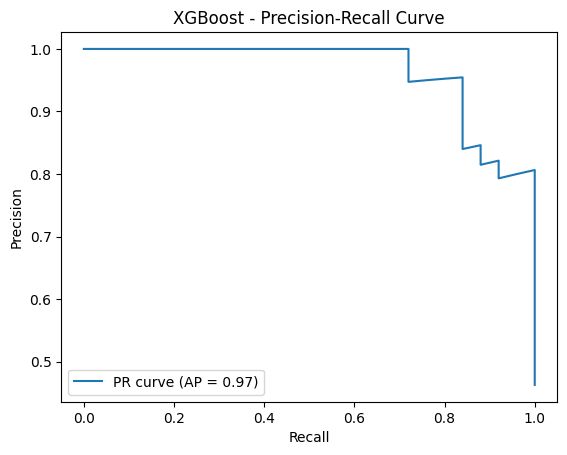

--------------------------------------------------
Evaluating Random Forest...
Cross-validated F1 Score: 0.7597598431489633
Accuracy: 0.8888888888888888
Precision: 0.8888888888888888
Recall: 0.8888888888888888
F1 Score: 0.8888888888888888
Confusion Matrix:
[[26  3]
 [ 3 22]]
AUC: 0.9655172413793103


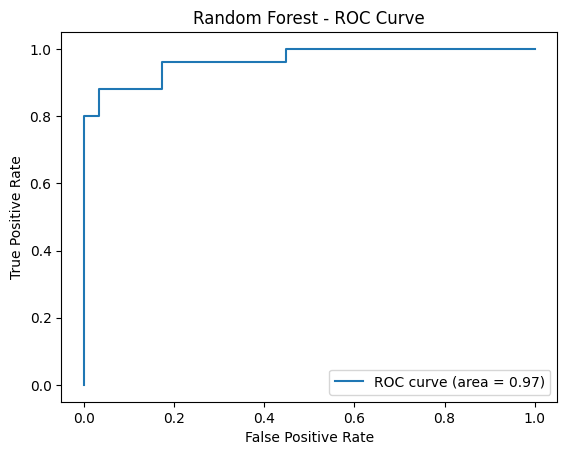

Average Precision (AP): 0.9687190683537247


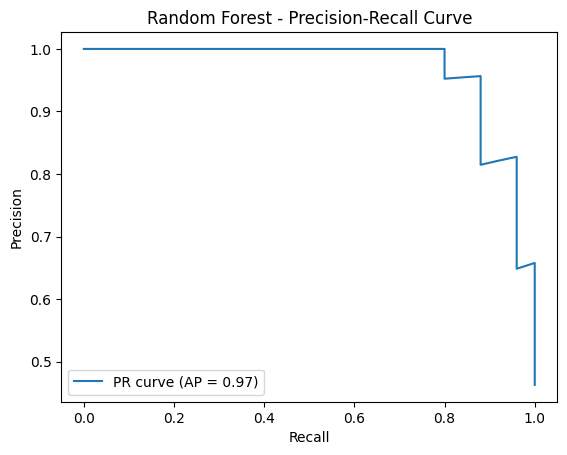

--------------------------------------------------
Evaluating SVM...
Cross-validated F1 Score: 0.5450261791781128
Accuracy: 0.5370370370370371
Precision: 0.7685185185185185
Recall: 0.5370370370370371
F1 Score: 0.43883277216610544
Confusion Matrix:
[[ 4 25]
 [ 0 25]]
AUC: 0.5558620689655173


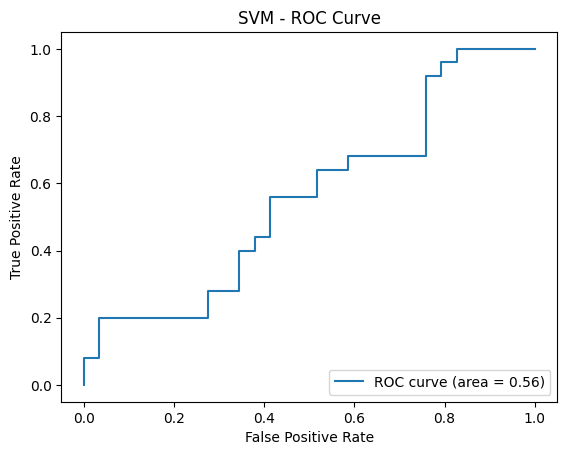

Average Precision (AP): 0.5672488539295188


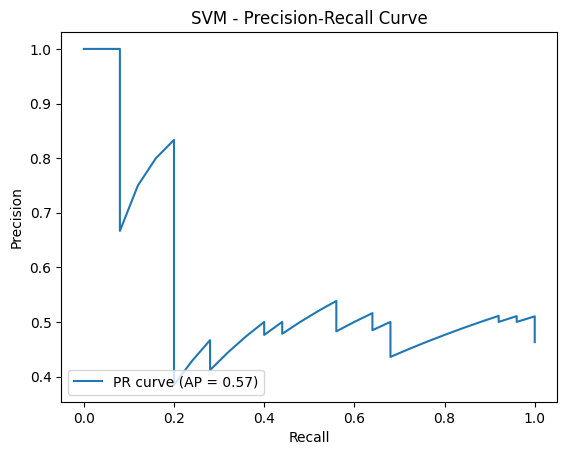

--------------------------------------------------
Evaluating AdaBoost...
Cross-validated F1 Score: 0.7438404996513264
Accuracy: 0.8703703703703703
Precision: 0.8712352462352463
Recall: 0.8703703703703703
F1 Score: 0.8705041470779343
Confusion Matrix:
[[25  4]
 [ 3 22]]
AUC: 0.9248275862068965


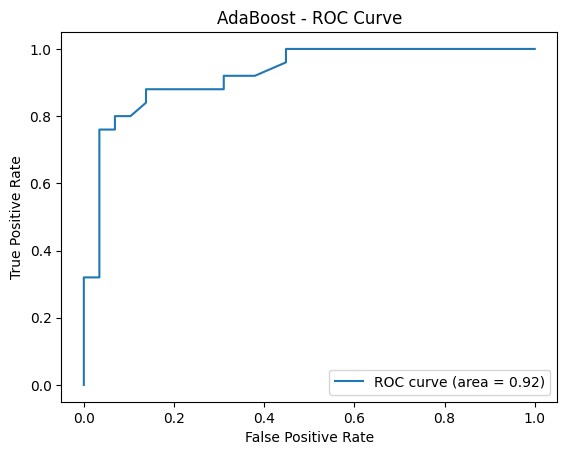

Average Precision (AP): 0.9147114380905402


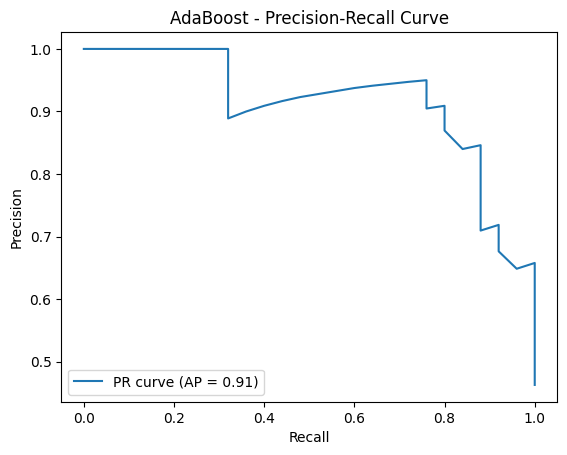

--------------------------------------------------
Evaluating KNN...
Cross-validated F1 Score: 0.6697968195688281
Accuracy: 0.8703703703703703
Precision: 0.8712352462352463
Recall: 0.8703703703703703
F1 Score: 0.8705041470779343
Confusion Matrix:
[[25  4]
 [ 3 22]]
AUC: 0.94


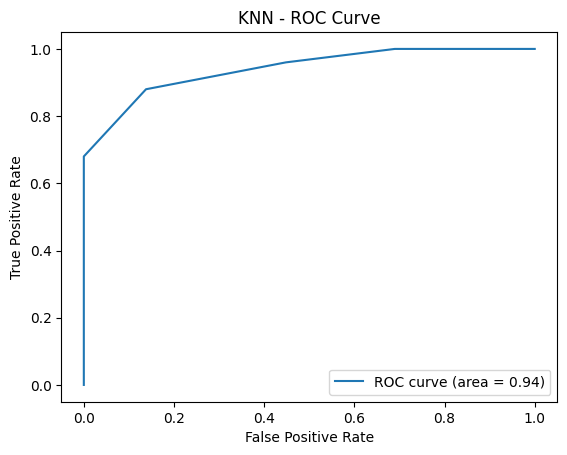

Average Precision (AP): 0.9233448833448834


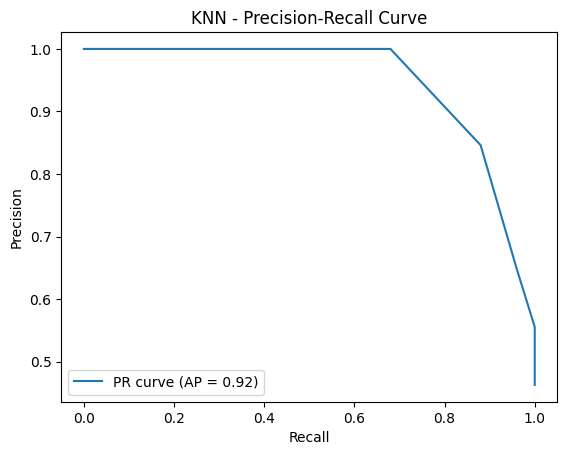

--------------------------------------------------
Evaluating Decision Tree...
Cross-validated F1 Score: 0.7180153413778271
Accuracy: 0.8148148148148148
Precision: 0.8148148148148148
Recall: 0.8148148148148148
F1 Score: 0.8148148148148148
Confusion Matrix:
[[24  5]
 [ 5 20]]
AUC: 0.8137931034482759


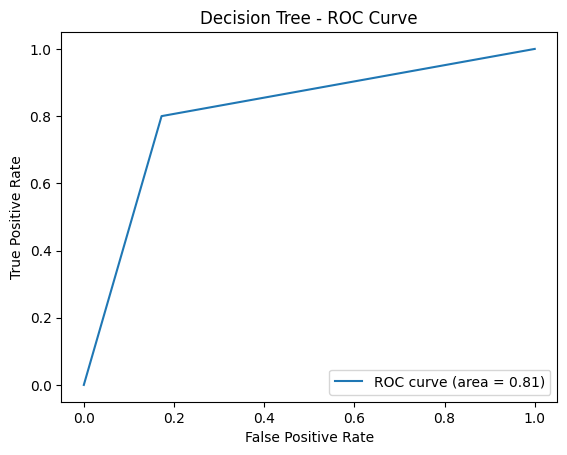

Average Precision (AP): 0.7325925925925927


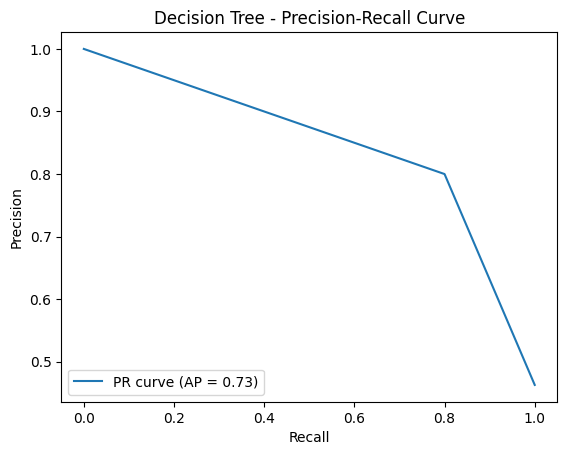

--------------------------------------------------
Evaluating Gradient Boosting...
Cross-validated F1 Score: 0.7165082242564607
Accuracy: 0.8333333333333334
Precision: 0.8342490842490842
Recall: 0.8333333333333334
F1 Score: 0.8335053319573442
Confusion Matrix:
[[24  5]
 [ 4 21]]
AUC: 0.950344827586207


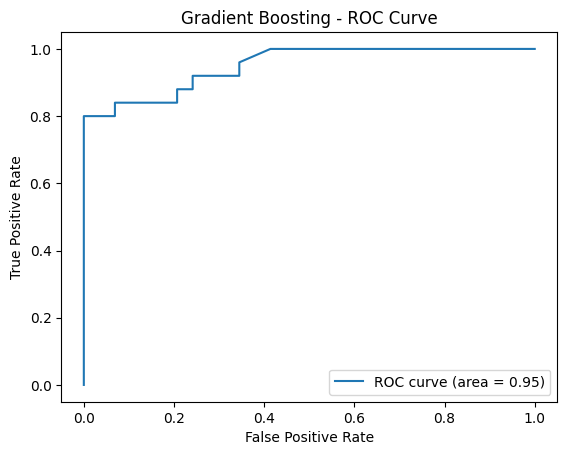

Average Precision (AP): 0.953879298370347


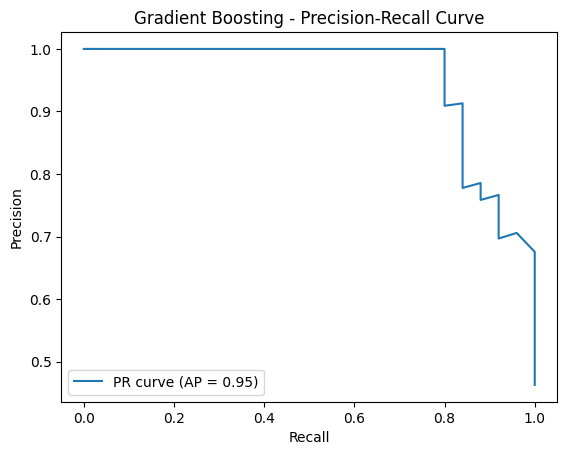

--------------------------------------------------
Evaluating Naive Bayes...
Cross-validated F1 Score: 0.5253488467567717
Accuracy: 0.5370370370370371
Precision: 0.7685185185185185
Recall: 0.5370370370370371
F1 Score: 0.43883277216610544


In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of models to evaluate
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "AdaBoost": AdaBoostClassifier(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB()
}

for name, model in models.items():
    print(f"Evaluating {name}...")

    # Cross-validated F1 Score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')
    print(f"Cross-validated F1 Score: {cv_scores.mean()}")

    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # Precision, Recall, F1 Score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix:\n{conf_matrix}")

    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"AUC: {roc_auc}")

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} - ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # PR Curve and AP
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
    ap_score = average_precision_score(y_test, y_prob)
    print(f"Average Precision (AP): {ap_score}")

    plt.figure()
    plt.plot(recall_vals, precision_vals, label=f'PR curve (AP = {ap_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name} - Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

    print("-" * 50)

Gradient Boosting Machines (GBM):

## Using cGAN to generate coding information of different data.

cGAN is more suitable to generate related models around the inverse designation of WCA laser processing tech.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

# Now we can read the file by its name.
data_path = 'drive/MyDrive/laser_WCA.xlsx'
data = pd.read_excel(data_path)
# Preprocess the dataset
data = data.drop(columns=['Unnamed: 13', 'Unnamed: 14', 'Data Source']).dropna()
data = pd.get_dummies(data, columns=['scanning method'])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Ensure all data is numeric by converting it to the appropriate type
for column in data.columns:
    data[column] = pd.to_numeric(data[column], errors='coerce')

# Convert DataFrame to PyTorch tensors
X = data.drop(columns=['WCA/°']).values.astype(np.float32)
y = data['WCA/°'].values.astype(np.float32)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Create a dataset and dataloader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Use this new generator and discriminator in your training loop

In [9]:
# Define the GAN model
input_dim = X.shape[1]
output_dim = y_tensor.shape[1]

generator = Generator(input_dim, output_dim)
discriminator = Discriminator(input_dim + output_dim)

# Loss and optimizer
criterion = nn.BCELoss()
# Adjusted learning rates
optimizer_G = optim.Adam(generator.parameters(), lr=0.00002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00001)

# Training loop with label smoothing and noise
num_epochs = 1000
for epoch in range(num_epochs):
    for i, (real_X, real_y) in enumerate(dataloader):
        # Train Discriminator
        optimizer_D.zero_grad()

        real_data = torch.cat((real_X, real_y), 1)
        real_labels = torch.FloatTensor(real_X.size(0), 1).uniform_(0.8, 1.0)  # Label smoothing within range [0.8, 1.0]

        fake_y = generator(real_X)
        fake_data = torch.cat((real_X, fake_y), 1)
        fake_labels = torch.FloatTensor(real_X.size(0), 1).uniform_(0.0, 0.2)  # Label smoothing within range [0.0, 0.2]

        real_output = discriminator(real_data)
        fake_output = discriminator(fake_data)

        real_loss = criterion(real_output, real_labels)
        fake_loss = criterion(fake_output, fake_labels)
        d_loss = real_loss + fake_loss

        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_y = generator(real_X)
        fake_data = torch.cat((real_X, fake_y), 1)
        fake_output = discriminator(fake_data)

        # Flip labels for generator training (target is real labels for fake output)
        g_loss = criterion(fake_output, torch.ones_like(fake_output))

        g_loss.backward()
        optimizer_G.step()

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")

print("GAN training complete.")

Epoch [0/1000] | D Loss: 1.5182812213897705 | G Loss: 0.733550488948822
Epoch [100/1000] | D Loss: 1.386519432067871 | G Loss: 0.686634361743927
Epoch [200/1000] | D Loss: 1.3856616020202637 | G Loss: 0.6924781203269958
Epoch [300/1000] | D Loss: 1.3862195014953613 | G Loss: 0.6931745409965515
Epoch [400/1000] | D Loss: 1.386972188949585 | G Loss: 0.6937238574028015
Epoch [500/1000] | D Loss: 1.3869882822036743 | G Loss: 0.6932299733161926
Epoch [600/1000] | D Loss: 1.3864355087280273 | G Loss: 0.6936883330345154
Epoch [700/1000] | D Loss: 1.3862979412078857 | G Loss: 0.6934888362884521
Epoch [800/1000] | D Loss: 1.3859460353851318 | G Loss: 0.6934176087379456
Epoch [900/1000] | D Loss: 1.387260913848877 | G Loss: 0.6934265494346619
GAN training complete.


In [15]:
# Example input parameters with placeholders (-1)
input_params = np.array([0.290, 250.0, -1, 114.81, 20.0, 400.0, 140.0, 800.0, 100, 1.0, 1, 18, 100, 160])

def predict_missing_parameters(generator, input_params):
    generator.eval()
    with torch.no_grad():
        # Convert input_params to a tensor and ensure it's the correct shape
        input_tensor = torch.tensor(input_params, dtype=torch.float32).unsqueeze(0)

        # Predict values for the placeholders
        predicted_values = generator(input_tensor).squeeze(0).numpy()

        # Replace placeholders in input_params with predicted values
        idx = 0
        for i in range(len(input_params)):
            if input_params[i] == -1:  # Placeholder for missing values
                input_params[i] = predicted_values[idx]
                idx += 1

    return input_params
# Predict the missing parameter(s) using the trained generator
predicted_params = predict_missing_parameters(generator, input_params)

# Output the result without scientific notation
np.set_printoptions(suppress=True)  # Suppress scientific notation
formatted_params = [f"{param:.2f}" for param in predicted_params]

print(f"Predicted Parameters: {formatted_params}")

Predicted Parameters: ['0.29', '250.00', '-2.30', '114.81', '20.00', '400.00', '140.00', '800.00', '100.00', '1.00', '1.00', '18.00', '100.00', '160.00']
